<a href="https://colab.research.google.com/github/RohannnCodes/STSCI5050-Final-Project/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving merged_final.csv to merged_final.csv


In [1]:
import pandas as pd
import numpy as np

In [59]:
df = pd.read_csv('merged_final.csv', index_col=0)
df["Winner"] = (df["Team1"] == df["WINNER_TEAM"]).astype(int)
df["Home"] = (df["Team1"] == df["HOME_TEAM"]).astype(int)
df.shape

(198, 18)

In [5]:
df_team1 = df.copy(deep=True)
df_team1["ORAPM"] = df_team1["AVG_ORAPM_Team1"] - df_team1["AVG_ORAPM_Team2"]
df_team1["DRAPM"] = df_team1["AVG_DRAPM_Team1"] - df_team1["AVG_DRAPM_Team2"]
df_team1["RELATIVE_RANK"] = (df_team1["AVG_RANK_Team1"] > df_team1["AVG_RANK_Team2"]).astype(int)
df_team1 = df_team1.drop(df_team1.columns[2:16], axis=1)
df_team1.head()

,Team1,Team2,Winner,Home,ORAPM,DRAPM,RELATIVE_RANK
GameID,,,,,,,
21600005,IND,DAL,1,1,0.202600,-0.446600,1
21600021,PHX,OKC,0,0,-0.014880,-1.029820,1
21600033,POR,DEN,1,0,0.109572,0.376575,0
21600039,WAS,MEM,0,0,0.673120,-0.867680,1
21600049,MIA,SAC,1,1,-0.557420,0.336260,1


In [6]:
df_team2 = df.copy(deep=True)
df_team2["ORAPM"] = df_team2["AVG_ORAPM_Team2"] - df_team2["AVG_ORAPM_Team1"]
df_team2["DRAPM"] =  df_team2["AVG_DRAPM_Team2"] - df_team2["AVG_DRAPM_Team1"]
df_team2["RELATIVE_RANK"] = (df_team2["AVG_RANK_Team1"] <= df_team2["AVG_RANK_Team2"]).astype(int)
df_team2["Team1"], df_team2["Team2"] = df_team2["Team2"], df_team2["Team1"]
df_team2["Winner"] = 1 - df_team2["Winner"]
df_team2["Home"] = 1 - df_team2["Home"]
df_team2 = df_team2.drop(df_team2.columns[2:16], axis=1)

df_team2.head()


,Team1,Team2,Winner,Home,ORAPM,DRAPM,RELATIVE_RANK
GameID,,,,,,,
21600005,DAL,IND,0,0,-0.202600,0.446600,0
21600021,OKC,PHX,1,1,0.014880,1.029820,0
21600033,DEN,POR,0,1,-0.109572,-0.376575,1
21600039,MEM,WAS,1,1,-0.673120,0.867680,0
21600049,SAC,MIA,0,0,0.557420,-0.336260,0


In [7]:
LR_df = pd.concat([df_team1, df_team2], axis=0)
LR_df.head(10)

,Team1,Team2,Winner,Home,ORAPM,DRAPM,RELATIVE_RANK
GameID,,,,,,,
21600005,IND,DAL,1,1,0.202600,-0.446600,1
21600021,PHX,OKC,0,0,-0.014880,-1.029820,1
21600033,POR,DEN,1,0,0.109572,0.376575,0
21600039,WAS,MEM,0,0,0.673120,-0.867680,1
21600049,MIA,SAC,1,1,-0.557420,0.336260,1
21600060,NOP,MEM,0,0,-0.874912,0.145305,1
21600063,POR,PHX,0,0,0.862532,0.057235,0
21600075,NOP,PHX,0,1,-0.096060,0.990920,0
21600090,MIL,DAL,0,0,0.742300,-1.410240,1


In [8]:
features = LR_df[["Home", "ORAPM", "DRAPM", "RELATIVE_RANK"]]
target = LR_df["Winner"]

In [9]:
import numpy as np

X_np = features.to_numpy().astype("float32")
y_np = target.to_numpy().astype("float32").reshape(-1, 1)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X_np).astype("float32")

In [11]:
from sklearn.model_selection import train_test_split

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled_np, y_np, test_size=0.2, random_state=42, shuffle=True
)

In [12]:
import torch

X_train = torch.from_numpy(X_train_np).float()
X_test = torch.from_numpy(X_test_np).float()

y_train = torch.from_numpy(y_train_np).float()
y_test = torch.from_numpy(y_test_np).float()

Logistic Regression Model

In [13]:
import torch
torch.__version__, torch.cuda.is_available()

('2.9.0+cu126', True)

In [14]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

In [16]:
class LogisticRegression:
    def __init__(self, dim):
        self.w = torch.randn(dim, 1, requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def sigmoid(self, z):
        return 1 / (1 + torch.exp(-z))

    def predict_proba(self, X):
        z = X @ self.w + self.b
        return self.sigmoid(z)

    def loss(self, X, y):
        p = self.predict_proba(X)
        loss = - (y * torch.log(p + 1e-12) + (1 - y) * torch.log(1 - p + 1e-12)).mean()
        return loss

In [17]:
model = LogisticRegression(dim=X_train.shape[1])
optimizer = torch.optim.SGD([model.w, model.b], lr=0.1)

for epoch in range(500):
    optimizer.zero_grad()
    loss = model.loss(X_train, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"epoch {epoch}, loss={loss.item():.4f}")

epoch 0, loss=1.1031
epoch 50, loss=0.7180
epoch 100, loss=0.6908
epoch 150, loss=0.6820
epoch 200, loss=0.6771
epoch 250, loss=0.6744
epoch 300, loss=0.6728
epoch 350, loss=0.6719
epoch 400, loss=0.6714
epoch 450, loss=0.6711


In [18]:
with torch.no_grad():
    probs = model.predict_proba(X_test)
    preds = (probs > 0.5).float()

accuracy = (preds == y_test).float().mean().item()

In [21]:
print(accuracy)

0.675000011920929


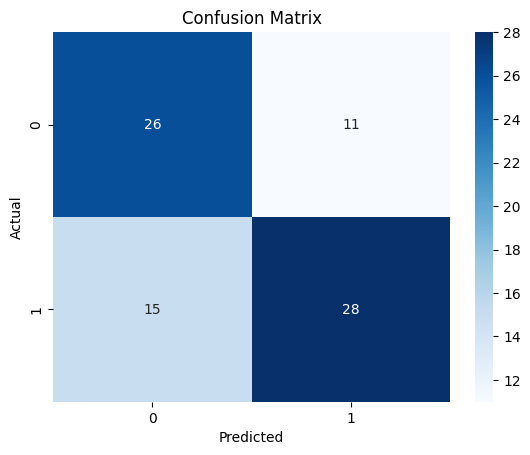

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

with torch.no_grad():
    probs_test = model.predict_proba(X_test).squeeze()

probs_test_np = probs_test.cpu().numpy()
y_test_np = y_test.cpu().numpy()

preds_test = (probs_test_np > 0.5).astype(int)
cm = confusion_matrix(y_test_np, preds_test)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
with torch.no_grad():
    probs_test = model.predict_proba(X_test).squeeze()

probs_test_np = probs_test.cpu().numpy()
y_test_np = y_test.cpu().numpy()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_np, probs_test_np)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

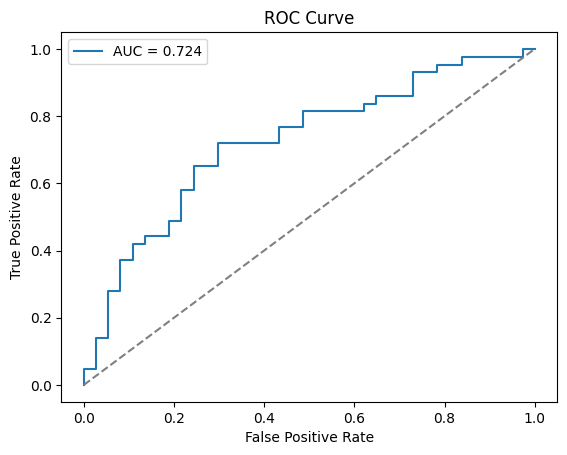

<Figure size 640x480 with 0 Axes>

In [26]:
with torch.no_grad():
    probs_test = model.predict_proba(X_test).squeeze()

probs_test_np = probs_test.cpu().numpy()
y_test_np = y_test.cpu().numpy()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_np, probs_test_np)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
plt.savefig("roc_curve.png", dpi=300)


In [25]:
plt.savefig("roc_curve.png", dpi=300)

<Figure size 640x480 with 0 Axes>

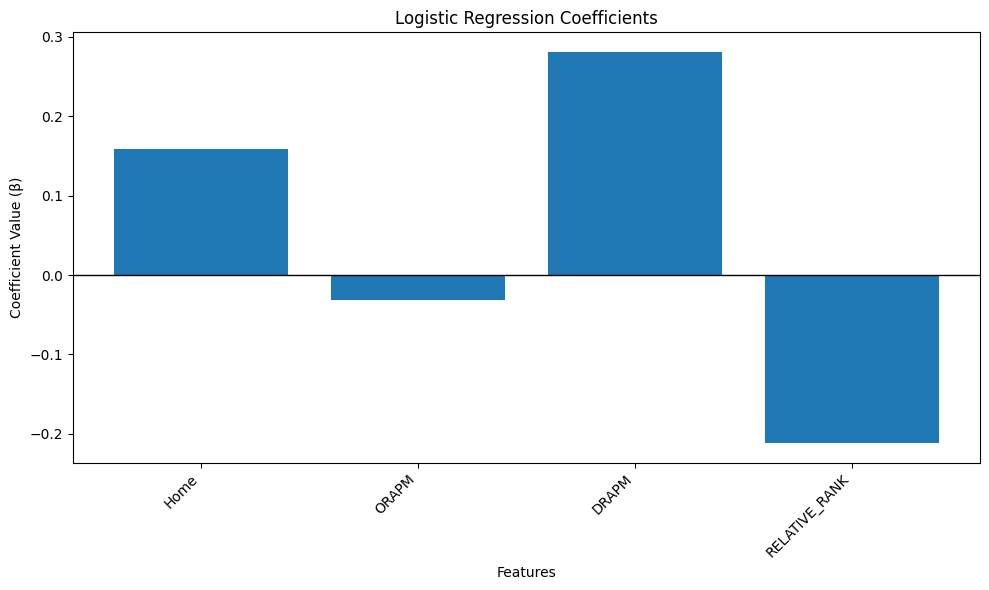

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extract coefficients from your model
betas = model.w.detach().cpu().numpy().flatten()
bias = model.b.detach().cpu().numpy().item()

feature_names = ["Home", "ORAPM", "DRAPM", "RELATIVE_RANK"]

plt.figure(figsize=(10, 6))
plt.bar(feature_names, betas)
plt.axhline(0, color="black", linewidth=1)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Coefficient Value (β)")
plt.title("Logistic Regression Coefficients")

plt.tight_layout()
plt.show()


In [36]:
# ranked lower but have a higher DRAPM than opponent

filtered_df = LR_df[(LR_df["RELATIVE_RANK"] == 0) & (LR_df["DRAPM"] > 0)]
filtered_df.shape
#filtered_df["Winner"].sum()

(137, 7)

In [38]:
# ranked lower have a higher DRAPM and home

filtered_df = LR_df[(LR_df["RELATIVE_RANK"] == 0) & (LR_df["DRAPM"] > 0) & (LR_df["Home"] == 1)]
filtered_df.shape
filtered_df["Winner"].sum()

np.int64(43)

In [63]:
filtered_df.shape

(60, 7)

In [76]:
# ranked lower have a higher DRAPM and home by season

df=df.reset_index()
df.head()

df = filtered_df.merge(df[["GameID", "season"]], on="GameID", how="left")

df_2016 = df[df['season'] == '2016-17']
df_2017 = df[df['season'] == '2017-18']
df_2018 = df[df['season'] == '2018-19']

#df_2016.shape[0], df_2017.shape, df_2018.shape
df_2016['Winner'].sum()/df_2016.shape[0], df_2017['Winner'].sum()/df_2017.shape[0], df_2018['Winner'].sum()/df_2018.shape[0]
#

(np.float64(0.7272727272727273),
 np.float64(0.8571428571428571),
 np.float64(0.5294117647058824))